In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn
import cv2
from tensorflow.keras.utils import to_categorical

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# 데이터 경로
data_path = "/content/drive/MyDrive/cloud_ai/16.모듈프로젝트04/workspace/"

In [4]:
# 이미지의 가로 세로
IMG_SIZE = 224
# 비디오에서 학습할 프레임 개수
MAX_SEQ_LENGTH = 20

In [5]:
# 학습 데이터의 파일명과 종류가 저장된 train.csv 를 읽음
train_df = pd.read_csv(data_path + "train.csv")


In [6]:
train_df

,video_name,tag
0,v_CricketShot_g08_c01.avi,CricketShot
1,v_CricketShot_g08_c02.avi,CricketShot
2,v_CricketShot_g08_c03.avi,CricketShot
3,v_CricketShot_g08_c04.avi,CricketShot
4,v_CricketShot_g08_c05.avi,CricketShot
...,...,...
351,v_TennisSwing_g25_c02.avi,TennisSwing
352,v_TennisSwing_g25_c03.avi,TennisSwing
353,v_TennisSwing_g25_c04.avi,TennisSwing
354,v_TennisSwing_g25_c05.avi,TennisSwing


In [7]:
# 비디오의 종류가 저장된 tag 컬럼을 label 컬럼에 대입
train_df["label"] = train_df["tag"]

In [8]:
train_df

,video_name,tag,label
0,v_CricketShot_g08_c01.avi,CricketShot,CricketShot
1,v_CricketShot_g08_c02.avi,CricketShot,CricketShot
2,v_CricketShot_g08_c03.avi,CricketShot,CricketShot
3,v_CricketShot_g08_c04.avi,CricketShot,CricketShot
4,v_CricketShot_g08_c05.avi,CricketShot,CricketShot
...,...,...,...
351,v_TennisSwing_g25_c02.avi,TennisSwing,TennisSwing
352,v_TennisSwing_g25_c03.avi,TennisSwing,TennisSwing
353,v_TennisSwing_g25_c04.avi,TennisSwing,TennisSwing
354,v_TennisSwing_g25_c05.avi,TennisSwing,TennisSwing


In [9]:
# label 컬럼에 저장된 데이터를 중복을 제거하고 조회
train_df["label"].unique()

array(['CricketShot', 'Punch', 'TennisSwing'], dtype=object)

In [10]:
# enumerate(train_df["label"].unique()) : label 컬럼에 저장된 데이터를 중복을 제거한 값에 인덱스 추가
for index, data in enumerate(train_df["label"].unique()):
    # label 컬럼에 저장된 data 를 index로 변환
    train_df["label"].replace(data, index, inplace=True) 

In [11]:
# label 컬럼에 저장된 값이 숫자로 변환 되었음
train_df

,video_name,tag,label
0,v_CricketShot_g08_c01.avi,CricketShot,0
1,v_CricketShot_g08_c02.avi,CricketShot,0
2,v_CricketShot_g08_c03.avi,CricketShot,0
3,v_CricketShot_g08_c04.avi,CricketShot,0
4,v_CricketShot_g08_c05.avi,CricketShot,0
...,...,...,...
351,v_TennisSwing_g25_c02.avi,TennisSwing,2
352,v_TennisSwing_g25_c03.avi,TennisSwing,2
353,v_TennisSwing_g25_c04.avi,TennisSwing,2
354,v_TennisSwing_g25_c05.avi,TennisSwing,2


In [12]:
# sklearn.utils.shuffle(train_df) : train_df에 저장된 행을 섞음
rain_df=sklearn.utils.shuffle(train_df)

In [13]:
# train_df에 저장된 줄이 섞였음
train_df

,video_name,tag,label
0,v_CricketShot_g08_c01.avi,CricketShot,0
1,v_CricketShot_g08_c02.avi,CricketShot,0
2,v_CricketShot_g08_c03.avi,CricketShot,0
3,v_CricketShot_g08_c04.avi,CricketShot,0
4,v_CricketShot_g08_c05.avi,CricketShot,0
...,...,...,...
351,v_TennisSwing_g25_c02.avi,TennisSwing,2
352,v_TennisSwing_g25_c03.avi,TennisSwing,2
353,v_TennisSwing_g25_c04.avi,TennisSwing,2
354,v_TennisSwing_g25_c05.avi,TennisSwing,2


In [14]:
# 비디오를 구성하는 이미지의 가운데 부분을 리턴
# frame : 비디오를 구성하는 이미지
def crop_center_square(frame):
    # frame.shape[0:2] : 이미지의 세로, 가로 리턴
    y, x = frame.shape[0:2]
    # 이미지의 세로 가로 중에서 작은 값을 리턴
    min_dim = min(y, x)
    #이미지의 왼쪽 모서리 좌표의 가로 시작점
    # 이미지 가로 좌표 (이미지 가로 //2  - min_dim//2) ~ (이미지 가로 //2  + min_dim//2) 
    start_x = (x // 2) - (min_dim // 2)
    # 이미지의 왼쪽 모서리 세로 좌표 시작점
    # 이미지 세로 좌표 (이미지 세로 //2  - min_dim//2) ~ (이미지 세로 //2  + min_dim//2) 
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]

In [15]:
# 비디오 파일을 읽어서 각 프레임을 이미지로 변환해서 리턴
# path : 비디오 파일 경로
# max_frames : 이미지로 변환할 프레임수
# resize=(IMG_SIZE, IMG_SIZE) : 이미지의 가로 세로
def load_video(path, max_frames=20, resize=(IMG_SIZE, IMG_SIZE)):
    # 비디오 파일을 읽어서 이미지로 변환 할 객페
    cap = cv2.VideoCapture(path)
    frames = []
    tmp = 0
    try:
        while True:
            # cap.read() : 비디오를 읽어서 리턴
            # ret : 비디오 읽기가 성공했으면 True, 더이상 읽을 비디오 프레임이 없으면 False 가 리턴
            # frame : 비디오 프레임 이미지를 리턴
            ret, frame = cap.read()
            # ret 가 False면 반복 종료
            if not ret:
                break
            # 비디오 이미지를 가운데 리턴
            frame = crop_center_square(frame)
            #비디오 이미지의 가로 세로를 resize=(224,224) 로 변환
            frame = cv2.resize(frame, resize)
            # frame 은  [줄, 칸, B G R ] 로 구성되 있음 
            # frame [ : (모든줄), : (모든칸), R (인덱스2) G (인덱스1) B (인덱스0 )] 리턴
            frame = frame[:, :, [2, 1, 0]]

            if tmp % 3 == 0:
                # frame을 frames에 추가
                frames.append(frame)
            tmp += 1
            # frames에 저장된 데이터수가 max_frames와 같으면 종료
            if len(frames) == max_frames:
                break
    finally:
        # 비디오 이미지 변환 종료
        cap.release()
    # frames를 numpy 배열로 변환 해서 리턴
    return np.array(frames)



In [16]:
# video 파일명 리턴
train_df["video_name"].loc[0]

'v_CricketShot_g08_c01.avi'

In [17]:
# 비디오 파일의 프레임을 이미지로 변환해서 리턴
video = load_video(data_path+"train/"+train_df["video_name"].loc[0])

In [18]:
# 비디오 파일 프레임 이미지 조회
video

array([[[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        ...,

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]],


       [[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0,

In [19]:
video.shape

(20, 224, 224, 3)

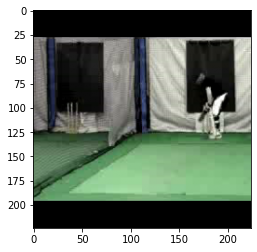

In [20]:
# 첫번째 프레임 출력
plt.imshow(video[0]/255)

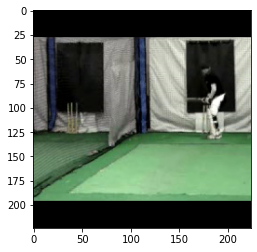

In [21]:
# 10번째 프레임 출력
plt.imshow(video[10]/255)

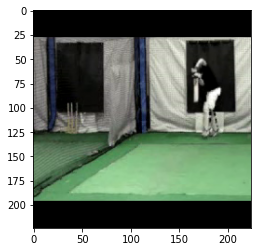

In [22]:
# 19번째 프레임 조회
plt.imshow(video[19]/255)

In [23]:
# 비디오 파일 종류 조회
train_df["label"].values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [24]:
# 비디오 파일의 종류를 2차원 배열로 변환
train_df["label"].values.reshape(-1,1)

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
    

In [25]:
# 모든 비디오 파일의 이미지와 종류를 리턴
# video_name : 비디오 파일명
# label: 비디오 파일 종류
# root_dir : 비디오 파일 경로
def prepare_all_videos(video_name , label, root_dir):
    # 비디오 파일 이름의 개수
    num_samples = len(video_name)
    # video_name.values.tolist() : 비디오 파일 이름을 리스트로 변환 해서 리턴
    video_paths = video_name.values.tolist()
    # 비디오 종류를 리턴
    labels = label.values
    # 비디오 종류를 2차원 배열로 변환
    labels = labels.reshape(-1,1)
    # labels를 float32 로 변환
    labels = np.array(labels , dtype="float32")
    # 0으로 초기화된 [비디오 파일개수 , 20 , 224 , 224, 3] 배열 생성 전체 비디오 저장
    x = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH, IMG_SIZE, IMG_SIZE, 3 ), dtype="float32" )
    # 비디오 파일의 개수 만큼 반복
    for idx, path in enumerate(video_paths):
        # 0으로 초기화된 [ 20 , 224 , 224, 3] 배열 생성 비디오 1개 저장
        video = np.zeros(shape=(MAX_SEQ_LENGTH, IMG_SIZE, IMG_SIZE, 3), dtype="float32")
        # 비디오 파일을 읽어서 각 프레임의 이미지를 리턴
        frames = load_video(root_dir+ path)
         # 프레임의 개수 만큼 반복
        for i in range(len(frames)):
             # frame의 i번째 이미지를 x에 추가
            video[i] = np.array(frames[i]/255, dtype="float32")
        # 비디오 1개의 정보를 x에 추가    
        x[idx] = video
    # 전체 비디오 프레임을 이미지로 변환한 x 
    # to_categorical(y) : 이미지의 종류 y 를 onehot 인코딩     
    return (x ,to_categorical(labels))

In [26]:
X_train, y_train = prepare_all_videos(train_df["video_name"], train_df["label"] , data_path + "train/")

In [27]:
# 전체 비디오 프레임을 이미지로 변환
X_train

array([[[[[0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          ...,
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ]],

         [[0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          ...,
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ]],

         [[0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          ...,
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ]],

         ...,

         [[0.        , 0.        , 0.        ],
          [0.        ,

In [28]:
X_train.shape

(356, 20, 224, 224, 3)

In [29]:
#비디오 종류
y_train

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [30]:
y_train.shape

(356, 3)

In [31]:
X_train[0].shape

(20, 224, 224, 3)

In [32]:
X_train[0][0].shape

(224, 224, 3)

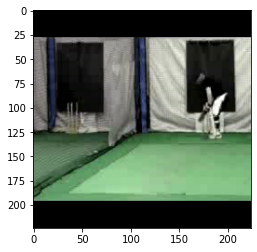

In [33]:
# 0번째 비디오 프레임 이미지
plt.imshow(X_train[0][0])

In [34]:
# 0번째 비디오 프레임 이미지 종류
y_train[0]

array([1., 0., 0.], dtype=float32)

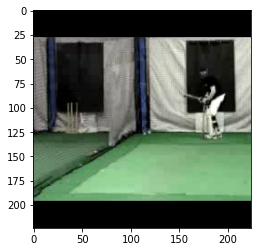

In [35]:
# 1번째 비디오 프레임 이미지
plt.imshow(X_train[1][0])

In [36]:
# 1번째 비디오 프레임 이미지 종류
y_train[1]

array([1., 0., 0.], dtype=float32)

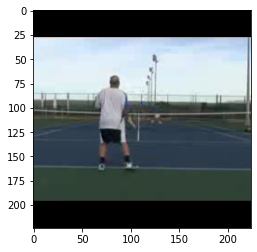

In [37]:
# 256번째 비디오 프레임 이미지
plt.imshow(X_train[256][0])

In [38]:
#  256 번째 비디오 프레임 이미지 종류
y_train[256]

array([0., 0., 1.], dtype=float32)

In [40]:
# 전처리된 train data 저장하기
np.save("/content/drive/MyDrive/sukhee/X_train_wide(5)", X_train)
np.save("/content/drive/MyDrive/sukhee/y_train_wide(5)", y_train)

# test data

In [41]:
data_path = '/content/drive/MyDrive/cloud_ai/16.모듈프로젝트04/workspace/'

In [42]:
# 테스트 비디오 파일명과 종류 리턴
test_df = pd.read_csv(data_path+"test.csv")

In [43]:
test_df

,video_name,tag
0,v_CricketShot_g01_c01.avi,CricketShot
1,v_CricketShot_g01_c02.avi,CricketShot
2,v_CricketShot_g01_c03.avi,CricketShot
3,v_CricketShot_g01_c04.avi,CricketShot
4,v_CricketShot_g01_c05.avi,CricketShot
...,...,...
132,v_TennisSwing_g07_c03.avi,TennisSwing
133,v_TennisSwing_g07_c04.avi,TennisSwing
134,v_TennisSwing_g07_c05.avi,TennisSwing
135,v_TennisSwing_g07_c06.avi,TennisSwing


In [44]:
# 비디오의 종류가 저장된 tag 컬럼을 label 컬럼에 대입
test_df["label"] = test_df["tag"]

In [45]:
test_df

,video_name,tag,label
0,v_CricketShot_g01_c01.avi,CricketShot,CricketShot
1,v_CricketShot_g01_c02.avi,CricketShot,CricketShot
2,v_CricketShot_g01_c03.avi,CricketShot,CricketShot
3,v_CricketShot_g01_c04.avi,CricketShot,CricketShot
4,v_CricketShot_g01_c05.avi,CricketShot,CricketShot
...,...,...,...
132,v_TennisSwing_g07_c03.avi,TennisSwing,TennisSwing
133,v_TennisSwing_g07_c04.avi,TennisSwing,TennisSwing
134,v_TennisSwing_g07_c05.avi,TennisSwing,TennisSwing
135,v_TennisSwing_g07_c06.avi,TennisSwing,TennisSwing


In [46]:
# enumerate(test_df["label"].unique()) : label 컬럼에 저장된 데이터를 중복을 제거한 값에 인덱스 추가
for index, data in enumerate(test_df["label"].unique()):
    # label 컬럼에 저장된 data 를 index로 변환
    test_df["label"].replace(data, index, inplace=True) 

In [47]:
# label 컬럼에 저장된 값이 숫자로 변환 되었음
test_df

,video_name,tag,label
0,v_CricketShot_g01_c01.avi,CricketShot,0
1,v_CricketShot_g01_c02.avi,CricketShot,0
2,v_CricketShot_g01_c03.avi,CricketShot,0
3,v_CricketShot_g01_c04.avi,CricketShot,0
4,v_CricketShot_g01_c05.avi,CricketShot,0
...,...,...,...
132,v_TennisSwing_g07_c03.avi,TennisSwing,2
133,v_TennisSwing_g07_c04.avi,TennisSwing,2
134,v_TennisSwing_g07_c05.avi,TennisSwing,2
135,v_TennisSwing_g07_c06.avi,TennisSwing,2


In [48]:
# sklearn.utils.shuffle(test_df) : test_df에 저장된 행을 섞음
test_df = sklearn.utils.shuffle(test_df)

In [49]:
# test_df에 저장된 줄이 섞였음
test_df

,video_name,tag,label
20,v_CricketShot_g03_c07.avi,CricketShot,0
88,v_TennisSwing_g01_c01.avi,TennisSwing,2
134,v_TennisSwing_g07_c05.avi,TennisSwing,2
91,v_TennisSwing_g01_c04.avi,TennisSwing,2
62,v_Punch_g04_c01.avi,Punch,1
...,...,...,...
65,v_Punch_g04_c04.avi,Punch,1
84,v_Punch_g07_c04.avi,Punch,1
58,v_Punch_g03_c01.avi,Punch,1
28,v_CricketShot_g05_c01.avi,CricketShot,0


In [50]:
# shuffle된 test.csv를 저장
#test_df.to_csv('/content/drive/MyDrive/4차 모듈 프로젝트_4조/data/shuffled_test.csv')

In [51]:
# 이미지의 가로 세로
IMG_SIZE = 224
# 비디오에서 학습할 프레임 개수
MAX_SEQ_LENGTH = 20

In [52]:
# 비디오를 구성하는 이미지의 가운데 부분을 리턴
# frame : 비디오를 구성하는 이미지
def crop_center_square(frame):
    # frame.shape[0:2] : 이미지의 세로, 가로 리턴
    y, x = frame.shape[0:2]
    # 이미지의 세로 가로 중에서 작은 값을 리턴
    min_dim = min(y, x)
    #이미지의 왼쪽 모서리 좌표의 가로 시작점
    # 이미지 가로 좌표 (이미지 가로 //2  - min_dim//2) ~ (이미지 가로 //2  + min_dim//2) 
    start_x = (x // 2) - (min_dim // 2)
    # 이미지의 왼쪽 모서리 세로 좌표 시작점
    # 이미지 세로 좌표 (이미지 세로 //2  - min_dim//2) ~ (이미지 세로 //2  + min_dim//2) 
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]

In [53]:
# 비디오 파일을 읽어서 각 프레임을 이미지로 변환해서 리턴
# path : 비디오 파일 경로
# max_frames : 이미지로 변환할 프레임수
# resize=(IMG_SIZE, IMG_SIZE) : 이미지의 가로 세로
def load_video(path, max_frames=20, resize=(IMG_SIZE, IMG_SIZE)):
    # 비디오 파일을 읽어서 이미지로 변환 할 객페
    cap = cv2.VideoCapture(path)
    frames = []
    tmp = 0
    try:
        while True:
            # cap.read() : 비디오를 읽어서 리턴
            # ret : 비디오 읽기가 성공했으면 True, 더이상 읽을 비디오 프레임이 없으면 False 가 리턴
            # frame : 비디오 프레임 이미지를 리턴
            ret, frame = cap.read()
            # ret 가 False면 반복 종료
            if not ret:
                break
            # 비디오 이미지를 가운데 리턴
            frame = crop_center_square(frame)
            #비디오 이미지의 가로 세로를 resize=(224,224) 로 변환
            frame = cv2.resize(frame, resize)
            # frame 은  [줄, 칸, B G R ] 로 구성되 있음 
            # frame [ : (모든줄), : (모든칸), R (인덱스2) G (인덱스1) B (인덱스0 )] 리턴
            frame = frame[:, :, [2, 1, 0]]

            if tmp % 3 == 0:
                # frame을 frames에 추가
                frames.append(frame)
            tmp += 1
            # frames에 저장된 데이터수가 max_frames와 같으면 종료
            if len(frames) == max_frames:
                break
    finally:
        # 비디오 이미지 변환 종료
        cap.release()
    # frames를 numpy 배열로 변환 해서 리턴
    return np.array(frames)



In [54]:
# video 파일명 리턴
test_df["video_name"].loc[0]

'v_CricketShot_g01_c01.avi'

In [55]:
# 비디오 파일의 프레임을 이미지로 변환해서 리턴
video = load_video(data_path+"test/"+test_df["video_name"].loc[0])

In [56]:
# 비디오 파일 프레임 이미지 조회
video

array([[[[ 27,  34,  32],
         [ 49,  56,  54],
         [ 57,  63,  64],
         ...,
         [ 39,  48,  31],
         [ 28,  37,  20],
         [ 24,  33,  17]],

        [[ 79,  86,  84],
         [ 96, 102, 101],
         [ 96, 102, 103],
         ...,
         [ 31,  40,  24],
         [ 34,  43,  27],
         [ 39,  48,  33]],

        [[110, 117, 115],
         [121, 128, 126],
         [112, 119, 122],
         ...,
         [ 25,  32,  28],
         [ 36,  43,  38],
         [ 44,  51,  46]],

        ...,

        [[ 90, 123,  59],
         [ 90, 123,  59],
         [ 90, 123,  59],
         ...,
         [ 97, 134,  72],
         [ 97, 134,  72],
         [ 97, 134,  72]],

        [[ 85, 118,  54],
         [ 85, 118,  54],
         [ 85, 118,  54],
         ...,
         [ 91, 128,  66],
         [ 91, 128,  66],
         [ 91, 128,  66]],

        [[ 81, 114,  50],
         [ 81, 114,  50],
         [ 81, 114,  50],
         ...,
         [ 75, 113,  50],
        

In [57]:
video.shape

(20, 224, 224, 3)

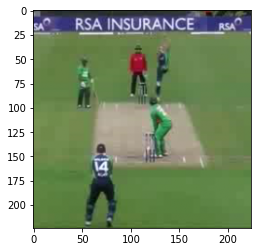

In [58]:
# 첫번째 프레임 출력
plt.imshow(video[0]/255)

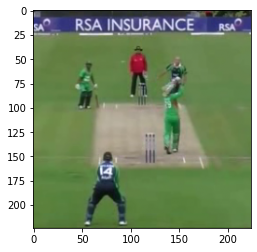

In [59]:
# 10번째 프레임 출력
plt.imshow(video[10]/255)

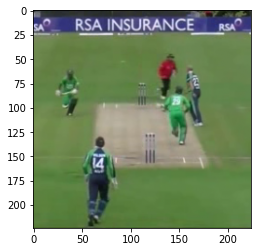

In [60]:
# 19번째 프레임 조회
plt.imshow(video[19]/255)

In [61]:
# 비디오 파일 종류 조회
test_df["label"].values

array([0, 2, 2, 2, 1, 0, 2, 1, 2, 1, 1, 1, 0, 2, 1, 2, 1, 0, 0, 1, 0, 2,
       2, 2, 2, 2, 2, 2, 0, 2, 1, 1, 2, 0, 2, 1, 0, 0, 0, 1, 0, 0, 2, 2,
       2, 0, 0, 1, 1, 2, 0, 2, 0, 0, 1, 2, 0, 1, 0, 2, 1, 1, 2, 2, 1, 0,
       0, 0, 2, 1, 0, 2, 1, 0, 0, 2, 1, 0, 2, 2, 1, 0, 1, 1, 2, 2, 2, 1,
       2, 1, 0, 2, 1, 1, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 1, 0, 2, 2, 2,
       0, 2, 2, 0, 0, 2, 2, 1, 2, 0, 0, 2, 1, 1, 0, 1, 2, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 1])

In [62]:
# 비디오 파일의 종류를 2차원 배열로 변환
test_df["label"].values.reshape(-1,1)

array([[0],
       [2],
       [2],
       [2],
       [1],
       [0],
       [2],
       [1],
       [2],
       [1],
       [1],
       [1],
       [0],
       [2],
       [1],
       [2],
       [1],
       [0],
       [0],
       [1],
       [0],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [0],
       [2],
       [1],
       [1],
       [2],
       [0],
       [2],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [2],
       [2],
       [2],
       [0],
       [0],
       [1],
       [1],
       [2],
       [0],
       [2],
       [0],
       [0],
       [1],
       [2],
       [0],
       [1],
       [0],
       [2],
       [1],
       [1],
       [2],
       [2],
       [1],
       [0],
       [0],
       [0],
       [2],
       [1],
       [0],
       [2],
       [1],
       [0],
       [0],
       [2],
       [1],
       [0],
       [2],
       [2],
       [1],
       [0],
       [1],
    

In [63]:
# 모든 비디오 파일의 이미지와 종류를 리턴
# video_name : 비디오 파일명
# label: 비디오 파일 종류
# root_dir : 비디오 파일 경로
def prepare_all_videos(video_name , label, root_dir):
    # 비디오 파일 이름의 개수
    num_samples = len(video_name)
    # video_name.values.tolist() : 비디오 파일 이름을 리스트로 변환 해서 리턴
    video_paths = video_name.values.tolist()
    # 비디오 종류를 리턴
    labels = label.values
    # 비디오 종류를 2차원 배열로 변환
    labels = labels.reshape(-1,1)
    # labels를 float32 로 변환
    labels = np.array(labels , dtype="float32")
    # 0으로 초기화된 [비디오 파일개수 , 20 , 224 , 224, 3] 배열 생성 전체 비디오 저장
    x = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH, IMG_SIZE, IMG_SIZE, 3 ), dtype="float32" )
    # 비디오 파일의 개수 만큼 반복
    for idx, path in enumerate(video_paths):
        # 0으로 초기화된 [ 20 , 224 , 224, 3] 배열 생성 비디오 1개 저장
        video = np.zeros(shape=(MAX_SEQ_LENGTH, IMG_SIZE, IMG_SIZE, 3), dtype="float32")
        # 비디오 파일을 읽어서 각 프레임의 이미지를 리턴
        frames = load_video(root_dir+ path)
         # 프레임의 개수 만큼 반복
        for i in range(len(frames)):
             # frame의 i번째 이미지를 x에 추가
            video[i] = np.array(frames[i]/255, dtype="float32")
        # 비디오 1개의 정보를 x에 추가    
        x[idx] = video
    # 전체 비디오 프레임을 이미지로 변환한 x 
    # to_categorical(y) : 이미지의 종류 y 를 onehot 인코딩     
    return (x ,to_categorical(labels))

In [64]:
X_test, y_test = prepare_all_videos(test_df["video_name"], test_df["label"] , data_path + "test/")

In [65]:

np.save('/content/drive/MyDrive/sukhee/X_test_wide(5).npy', X_test)
np.save('/content/drive/MyDrive/sukhee/y_test_wide(5).npy', y_test)
